In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchvision as tv
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [2]:
BATCH_SIZE=64

In [3]:
train_dataset = tv.datasets.MNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.MNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

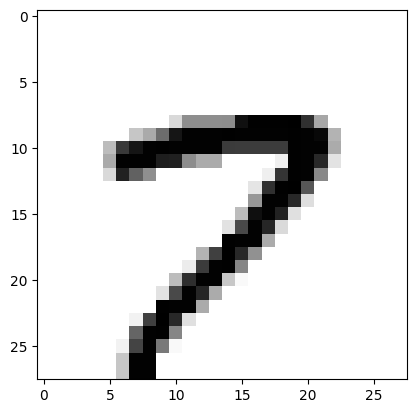

In [5]:
plt.imshow(train_dataset[123][0].numpy().reshape(28,28), cmap='gray_r');

In [6]:
train_dataset[123][0].numpy().shape

(1, 28, 28)

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [8]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=50, bias=True). X shape: torch.Size([1, 50])
Layer ReLU(). X shape: torch.Size([1, 50])
Layer Linear(in_features=50, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [9]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [10]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
dev

device(type='cuda')

In [12]:
model = model.to(dev)

In [13]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [14]:
def train_model(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [15]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.5456, train acc 0.824, test acc 0.952
epoch 2, loss 0.0950, train acc 0.971, test acc 0.967
epoch 3, loss 0.0687, train acc 0.979, test acc 0.973
epoch 4, loss 0.0563, train acc 0.983, test acc 0.978
epoch 5, loss 0.0481, train acc 0.985, test acc 0.982
epoch 6, loss 0.0424, train acc 0.987, test acc 0.985
epoch 7, loss 0.0377, train acc 0.989, test acc 0.985
epoch 8, loss 0.0340, train acc 0.990, test acc 0.986
epoch 9, loss 0.0305, train acc 0.991, test acc 0.987
epoch 10, loss 0.0277, train acc 0.992, test acc 0.987
CPU times: user 1min 27s, sys: 593 ms, total: 1min 27s
Wall time: 1min 30s


При самом удачном запуске train acc достигла 99%, но в среднем получалось что-то в районе 96-97%. test acc около 96-97%


In [16]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=5, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=2),
    nn.MaxPool2d(2, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.BatchNorm1d(4608),
    nn.Linear(4608, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 10),
).to(dev)
lr, num_epochs = 0.0003, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.1370, train acc 0.959, test acc 0.980
epoch 2, loss 0.0558, train acc 0.983, test acc 0.978
epoch 3, loss 0.0423, train acc 0.987, test acc 0.986
epoch 4, loss 0.0365, train acc 0.989, test acc 0.987
epoch 5, loss 0.0313, train acc 0.990, test acc 0.987
epoch 6, loss 0.0257, train acc 0.992, test acc 0.988
epoch 7, loss 0.0232, train acc 0.993, test acc 0.990
epoch 8, loss 0.0223, train acc 0.993, test acc 0.986
epoch 9, loss 0.0197, train acc 0.993, test acc 0.990
epoch 10, loss 0.0162, train acc 0.995, test acc 0.989
CPU times: user 2min 5s, sys: 630 ms, total: 2min 5s
Wall time: 2min 14s


Сверточной сетью удалось приблизить train acc к 100%, и test acc тоже

In [17]:
y_true = []
y_pred_2 = []
for X, y in test:
  X, y = X.to(dev), y.to(dev)
  y_pred_1 = model(X)
  y_true.extend(y)
  y_pred_2.extend(y_pred_1.argmax(dim=1))

In [18]:
y_true = [i.item() for i in y_true]
y_pred_2 = [i.item() for i in y_pred_2]

In [19]:
conf_mx = confusion_matrix(y_true, y_pred_2, normalize="pred")

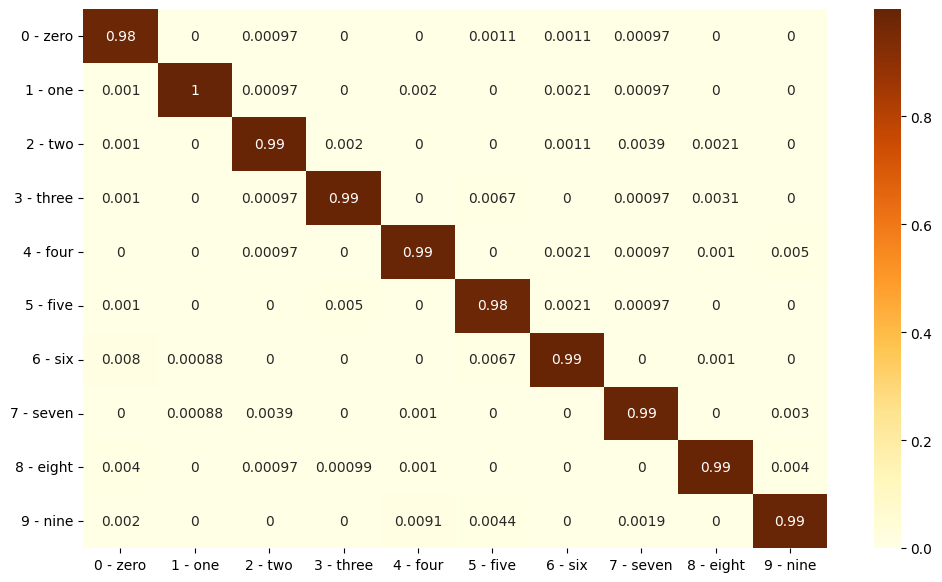

In [20]:
df_cm = pd.DataFrame(conf_mx, index=test_dataset.class_to_idx,
                     columns=test_dataset.classes)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap="YlOrBr");

некоторые незначительные misclassifications наблюдаются между цифрами 5 и 3, 5 и 6, 6 и 0, 8 и 3, 9 и 4 и 9 и 5, но в целом, модель работает с высокой точностью и имеет мало ошибок распознавания.